In [1]:
#This is the notebook to set and train the clusterer

PATH_TO_CLUSTERS = '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/assets/clusters_Belgium.csv'
PATH_OUT = '/Users/augustecousin/Documents/bel_gm_tool/gm_tool/assets/'

In [2]:
import sys
sys.path.insert(0,"/Users/augustecousin/Documents/bel_gm_tool/gm_tool/")

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from datamanager.DM_Belgique import DM_Belgique

In [4]:
"""load data from csv into DataManager"""
path = '../../../../Pivot & Co/Bel 2022 - 1. Growth Modelling/2. Design (Tool)/_Raoul/220207_Belgium_Dataset.csv'
data_manager = DM_Belgique()
data_manager.open_excel(path)
data_manager.df.rename(columns={'ACV': 'Distribution'}, inplace=True)
#SHAPE (17160, 14)

In [5]:
"""load clusters_Belgium.csv"""
clusters = pd.read_csv(PATH_TO_CLUSTERS)
#SHAPE (234, 4)

In [6]:
"""merge clusters into dataset, (reduce dataset to [Category, Brand, Sub Category] that are in clusters)"""
df_merged = pd.merge(clusters, data_manager.df, on=['Category', 'Brand', 'Sub Category'])
#SHAPE (9360, 15)

In [7]:
"""log Distribution and Price"""
df_merged['Distribution'] = df_merged['Distribution'].apply(np.log1p)
df_merged['Price per volume'] = df_merged['Price per volume'].apply(np.log1p)

In [8]:
"""sub dataframe as groupby [Category, Sub Category, Brand]"""
df_sub = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Cluster', 'Number of Categories', 'Number of Sub Categories'].max()
#SHAPE (234, 6)

/var/folders/3n/8sjtl4yd5k518vq7tdlbr_nm0000gn/T/ipykernel_30808/3177445698.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sub = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Cluster', 'Number of Categories', 'Number of Sub Categories'].max()


In [9]:
"""compute high level metrics for time series of Distribution and Price per volume : min, max, mean, std"""
Distribution = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Distribution'].agg(
    {'min Distribution':'min', 'max Distribution':'max', 'mean Distribution':'mean', 'std Distribution':'std'}
)


Price = df_merged.groupby(['Category', 'Sub Category', 'Brand'], as_index=False)['Price per volume'].agg(
    {'min Price':'min', 'max Price':'max', 'mean Price':'mean', 'std Price':'std'}
)

In [10]:
"""merge high level metrics into df_sub"""
df_sub = pd.merge(df_sub, Distribution, on=['Category', 'Sub Category', 'Brand'])

df_sub = pd.merge(df_sub, Price, on=['Category', 'Sub Category', 'Brand'])
#SHAPE (234, 14)

In [11]:
"""train RandomForestClassifier to classify [Category, Sub Category, Brand] in the correct clusters"""
clf = RandomForestClassifier(max_depth=6, random_state=0)

X = df_sub.loc[:, ~df_sub.columns.isin(['Brand', 'Category', 'Sub Category', 'Cluster'])].astype(float)
y = df_sub['Cluster'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=6, random_state=0)

In [12]:
"""save model"""
#pickle.dump(clf, open(PATH_OUT+'classifier_Belgium.sav', 'wb'))

'save model'

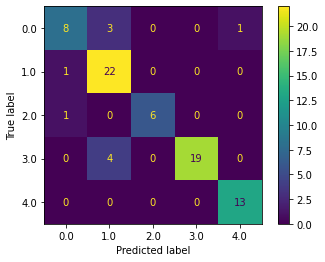

In [13]:
"""Confusion matrix to evaluate the classifier"""
y_pred=clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()